In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))



from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
casestore = {}

In [ ]:
class Load:
    def __init__(self):
        pass

    def case_1D(casepath):
        
        datapath = os.path.join(casepath, "BOUT.dmp.*.nc")
        inputfilepath = os.path.join(casepath, "BOUT.inp")

        ds = xbout.load.open_boutdataset(
                datapath = datapath, 
                inputfilepath = inputfilepath, 
                info = False,
                keep_yboundaries=True,
                cache = False
                )

        ds = ds.squeeze(drop = True)

        return Case(ds, casepath, unnormalise_geom = True)

    def case_2D(casepath, 
                gridfilepath = None, 
                verbose = False, 
                keep_boundaries = None, 
                keep_xboundaries = False,
                keep_yboundaries = False,
                squeeze = True, 
                double_load = False,
                unnormalise_geom = False,
                unnormalise = True):
        """ 
        Double load returns a case with and without guards.
        """
        
        if keep_xboundaries == True or keep_boundaries == True:
            xboundaries = True
        else:
            xboundaries = False
        if keep_yboundaries == True or keep_boundaries == True:
            yboundaries = True
        else:
            yboundaries = False
            
        datapath = os.path.join(casepath, "BOUT.dmp.*.nc")
        inputfilepath = os.path.join(casepath, "BOUT.inp")

        # Load both a case with and without guards
        if double_load is True:
            
            ds = xbout.load.open_boutdataset(
                datapath = datapath, 
                inputfilepath = inputfilepath, 
                gridfilepath = gridfilepath,
                info = False,
                cache = False,
                geometry = "toroidal",
                keep_xboundaries=True,
                keep_yboundaries=True,
                )
            
            ds_ng = xbout.load.open_boutdataset(
                datapath = datapath, 
                inputfilepath = inputfilepath, 
                gridfilepath = gridfilepath,
                info = False,
                cache = False,
                geometry = "toroidal",
                keep_xboundaries=False,
                keep_yboundaries=False,
                )
            
            if squeeze:
                ds = ds.squeeze(drop = True)
                ds_ng = ds_ng.squeeze(drop = True)
                
            return Case(ds, casepath, unnormalise_geom), Case(ds_ng, casepath, unnormalise_geom)
                
        else:
            
            # Load with guard settings as per inputs
            ds = xbout.load.open_boutdataset(
                datapath = datapath, 
                inputfilepath = inputfilepath, 
                gridfilepath = gridfilepath,
                info = False,
                geometry = "toroidal",
                keep_xboundaries=xboundaries,
                keep_yboundaries=yboundaries,
                )
            
            if squeeze:
                ds = ds.squeeze(drop = False)
                
            return Case(ds, casepath, 
                        unnormalise_geom,
                        unnormalise = unnormalise)

In [2]:
db = CaseDB(
    # case_dir = r"/ssd_scratch/hcases",
    # grid_dir = r"/ssd_scratch/hcases"
    )

# toload = [
#     dict(name="base", id="x5a2-better_base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
#     dict(name="reference", id="d4d-fit_nsep3", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

# ]


# for case in toload:
#     casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
#                                             double_load = False, keep_xboundaries = True, keep_yboundaries = True,
#                                             unnormalise_geom = case["unnormalise_geom"])


In [8]:
db.casepaths['x5a2b-better_base_edge_recycling']

WindowsPath('c:/Users/mikek/OneDrive/Project/collab/tech/cases/scratchtest/x5a2b-better_base_edge_recycling')

In [10]:
db.gridpaths[]

WindowsPath('c:/Users/mikek/OneDrive/Project/collab/tech/cases/scratchtest/x5a2b-better_base_edge_recycling')

In [19]:
from boutdata.squashoutput import squashoutput
from datetime import datetime as dt

use_squash = True
recreate_squash = False
verbose = True
id = "x5a2-better_base"
grid = "g3b1-lores_newhypno.nc"
casepath = db.casepaths[id]
gridfilepath = db.gridpaths[grid]
datapath = os.path.join(casepath, "BOUT.dmp.*.nc")
inputfilepath = os.path.join(casepath, "BOUT.inp")
squashfilepath = os.path.join(casepath, "BOUT.squash.nc") # Squashoutput hardcoded to this filename

recreate = True if recreate_squash is True else False   # Recreate squashoutput?

if use_squash is True:
    if verbose is True: print(f"- Using squashoutput for reading")
    
    if "BOUT.squash.nc" in os.listdir(casepath):  # Squash file found?
        
        squash_date = os.path.getmtime(squashfilepath)
        dmp_date = os.path.getmtime(os.path.join(casepath, "BOUT.dmp.0.nc"))
        
        if verbose is True: print(f"- Squash file found. squash date {dt.fromtimestamp(squash_date)}, dmp file date {dt.fromtimestamp(dmp_date)}") 

        
        
        if dmp_date > squash_date:   #f"- Squashoutput i Recreate if squashoutput is too old
            recreate = True
            if verbose is True: print(f"old: squash date {dt.fromtimestamp(squash_date)}, dmp file date {dt.fromtimestamp(dmp_date)}") 
            
    else:
        if verbose is True: print(f"- Squashoutput file not found, creating")
        recreate = True
        
    
    if recreate is True:
        squashoutput(
            datadir = casepath,
            outputname = squashfilepath,
            xguards = True,   # Take all xguards
            yguards = "include_upper",  # Take all yguards (yes, confusing name)
            parallel = False,   # Seems broken atm
            quiet = verbose
        )


- Using squashoutput for reading
- Squash file found. squash date 2023-08-09 14:48:59.162416, dmp file date 2023-07-31 12:23:23


In [20]:
squash_date > dmp_date

True

In [16]:
dt.strftime(dt.fromtimestamp(squash_date), "%d %B, %Y")

'09 August, 2023'

In [19]:
%pip install datetime

  Obtaining dependency information for datetime from https://files.pythonhosted.org/packages/95/88/3b9d4042b396221a132180b392ab2a174031a6fb579f7927f3909fc183a7/DateTime-5.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/204.1 kB ? eta -:--:--
     ----------------- --------------------- 92.2/204.1 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 204.1/204.1 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/52.2 kB ? eta -:--:--
   ---------------------------------------- 52.2/52.2 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# New particle balance

In [101]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, force_neumann = False)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)
    # casestore[name].ds = calculate_heat_balance(casestore[name].ds)
    # casestore[name].ds = calculate_particle_balance(casestore[name].ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


In [36]:
casestore["base"].ds["pf_recycle_inner_lower_target_d"].dims

('t', 'x')

In [ ]:
casestore["base"].ds.data_vars

In [109]:
ds = casestore["base"].ds

m = ds.metadata
    
core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
pfr = ds.hermesm.select_region("pfr_edge")
domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_volume = domain["dv"].values.sum()
vars = ds.data_vars

df = pd.DataFrame()
pf = dict()

# Radial and edge fluxes
# The summing is clunky but there's apparently no other way in Xarray!
net = dict()

for place in ["src", "core", "sol", "pfr"]:
    net[f"pf_int_{place}_net"] = 0

### Calculate all integrals of edge fluxes and sources
for species in m["ion_species"] + m["neutral_species"]:
    ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
    ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
    ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
    ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()

    # Add to net counter for each location
    for place in ["src", "core", "sol", "pfr"]:
        net[f"pf_int_{place}_net"] += ds[f"pf_int_{place}_{species}"]
    
### Calculate all integrals of recycling sources
for species in m["recycle_pair"].values():
    if f"S{species}_sol_recycle" in vars:
        ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_pfr_recycle" in vars:
        ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_target_recycle" in vars:
        ds[f"pf_int_recycle_target_{species}"] = (domain[f"S{species}_target_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        
    # Add to net counters for each location apart from sources since there are no user set recycling sources
    # Also add to the targets net counter (recycling sources per target basis not done yet)
    for place in ["sol", "pfr", "targets"]:   # No recycling in core, but yes in targets
        if f"pf_int_recycle_{place}_{species}" in vars:
            net[f"pf_int_{place}_net"] += ds[f"pf_int_recycle_{place}_{species}"]
    
### Calculate integrals of target fluxes
# Initialise per-target net counter
for target_name in m["targets"]:
    net[target_name] = 0
net["targets"] = 0



        
## Capture ion species (flux leaving model)
for species in m["ion_species"]:
    net[f"targets_{species}"] = 0 # TODO: Not sure why we need a net per species?
    
    for target_name in m["targets"]:
        ds[f"pf_int_{target_name}_target_{species}"] = ds[f"pf_{target_name}_target_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_{target_name}_target_{species}"]   # Ion flux
        net[f"targets_{species}"] += ds[f"pf_int_{target_name}_target_{species}"] # TODO: Not sure why we need a net per species?
    
## Capture recycled species (sources entering model)
for species in m["recycle_pair"].values():
    net[f"targets_{species}"] = 0 # TODO: Not sure why we need a net per species?
    
    for target_name in m["targets"]:
        ds[f"pf_int_recycle_{target_name}_target_{species}"] = ds[f"pf_recycle_{target_name}_target_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_recycle_{target_name}_target_{species}"]   # Recycling flux
        net[f"targets_{species}"] += ds[f"pf_int_recycle_{target_name}_target_{species}"] # TODO: Not sure why we need a net per species?
        
for species in m["ion_species"] + list(m["recycle_pair"].values()):
    ds[f"pf_int_targets_{species}"] = net[f"targets_{species}"] # TODO: Not sure why we need a net per species?
        
# Get the all target net counter
# Put the net counters into the dataset
for target_name in m["targets"]:
    ds[f"pf_int_{target_name}_target_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]


### Atomic reaction fluxes
for ion in m["ion_species"]:
    
    if f"S{ion}_iz" in domain.data_vars:
        neutral = ion.split("+")[0]
        ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
    
    if f"S{ion}_rec" in domain.data_vars:
        ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1

# Note: no "net" ionisation or recombination since they net out to zero.

### Put the net sums in each location into the dataset
for place in ["src", "core", "sol", "pfr"]:
    ds[f"pf_int_{place}_net"] = net[f"pf_int_{place}_net"]
    
for target_name in m["targets"]:
    ds[f"pf_int_{target_name}_target_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]

### Calculate the total net balance
ds[f"pf_int_total_net"] = \
    ds["pf_int_src_net"] + ds["pf_int_core_net"] + ds["pf_int_sol_net"] + ds["pf_int_pfr_net"] \
        + ds["pf_int_targets_net"]

In [ ]:
ds.data_vars

In [110]:
df = pd.DataFrame()
df.index = ["source", "core", "sol", "sol recycle", "pfr", "pfr recycle", "targets", "targets recycle", "iz", "rec"]
m = ds.metadata

if f"pf_int_{m['targets'][0]}" in ds.data_vars:
    merge_targets = False
else:
    merge_targets = True

last = ds.isel(t=-1)
for species in m["ion_species"] + m["neutral_species"]:
    df.loc["source", species] = last[f"pf_int_src_{species}"]
    df.loc["core", species] = last[f"pf_int_core_{species}"]
    df.loc["sol", species] = last[f"pf_int_sol_{species}"]
    df.loc["pfr", species] = last[f"pf_int_pfr_{species}"]
    
for species in m["ion_species"]:
    if merge_targets is True:
        df.loc["targets", species] = last[f"pf_int_targets_{species}"]
    else:
        for target in m["targets"]:
            df.loc[target, species] = last[f"pf_int_{target}_{species}"]
    
for species in m["ion_species"] + m["neutral_species"]:
    if f"pf_int_iz_{species}" in last.keys():
        df.loc["iz", species] = last[f"pf_int_iz_{species}"]
    if f"pf_int_rec_{species}" in last.keys():
        df.loc["rec", species] = last[f"pf_int_rec_{species}"]
        
for species in m["recycle_pair"].values():
    if f"pf_int_recycle_sol_{species}" in vars:
        df.loc["sol recycle", species] = last[f"pf_int_recycle_sol_{species}"]
    if f"pf_int_recycle_pfr_{species}" in vars:
        df.loc["pfr recycle", species] = last[f"pf_int_recycle_pfr_{species}"]
    if f"pf_int_recycle_target_{species}" in vars:
        df.loc["targets recycle", species] = last[f"pf_int_recycle_target_{species}"]
    
df["total"] = df.sum(axis=1)
imbalance = df["total"].sum()
imbalance_frac = imbalance / (df["total"]["source"] + df["total"]["core"])

# print(f"Recycling fraction: {frec:.2%}")
print(f"Domain volume: {ds['dv'].sum():.3e} [m3]")
print(f"Particle imbalance: {imbalance:,.3e} [s-1]")
print(f"Particle imbalance as frac of core + source: {imbalance_frac:.2%}")
print("---------------------------------------")
print(f"Total fluxes in [s-1]:")

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.copy().style.format("{:.2e}")
ts = ts.applymap(styler)
display(ts)

Domain volume: 1.607e+00 [m3]
Particle imbalance: -4.566e+19 [s-1]
Particle imbalance as frac of core + source: -14.84%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,3.08e+20,0.00e+00,3.08e+20
sol,-0.00e+00,-0.00e+00,0.00e+00
sol recycle,nan,nan,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
pfr recycle,nan,nan,0.00e+00
targets,-6.97e+21,nan,-6.97e+21
targets recycle,nan,6.62e+21,6.62e+21
iz,6.62e+21,-6.62e+21,0.00e+00
rec,-2.03e+18,2.03e+18,0.00e+00


In [ ]:
ds.data_vars

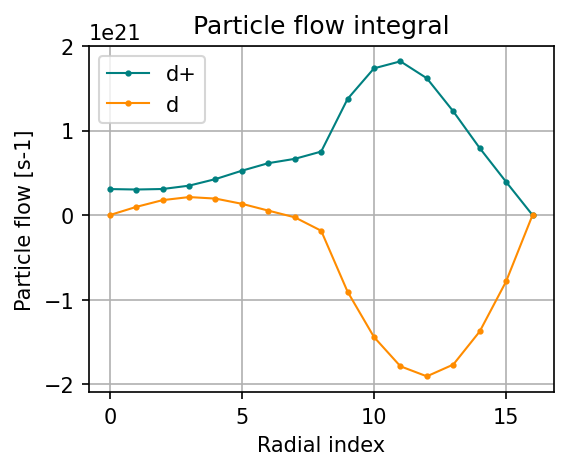

In [108]:
plot_perp_particle_fluxes(ds.isel(t=-1))

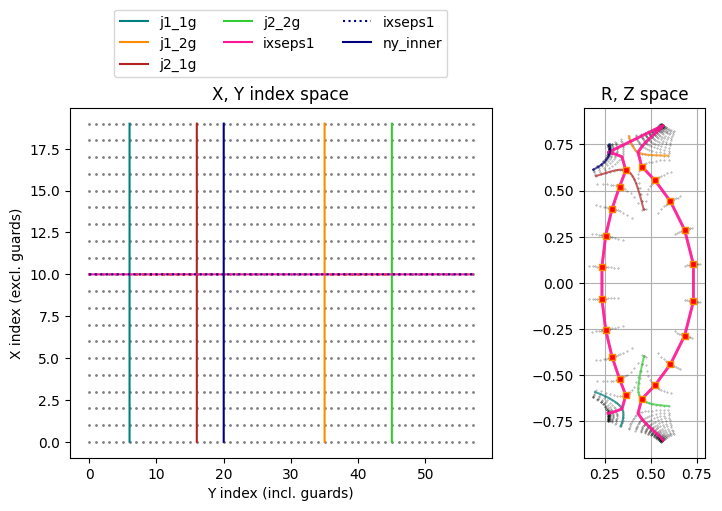

In [115]:
core = ds.hermesm.select_custom_core_ring(8)
plot_selection(ds, core)

In [116]:

# core = ds.hermesm.select_custom_core_ring(0)
core["ParticleFlow_d+_xlow"].sum("theta").isel(t=-1).values


array([-1.72072594e+21])

In [118]:
ions = core[f"pf_perp_diff_L_d+"].sum("theta").isel(t=-1).values
neutrals = core[f"pf_perp_diff_L_d"].sum("theta").isel(t=-1).values
print(ions)
print(neutrals)
print(ions+neutrals)

[1.72072594e+21]
[-1.4129915e+21]
[3.07734443e+20]


In [80]:
out = -6.97e21+6.62e21

out

-3.499999999999995e+20

In [98]:
ds.data_vars

Data variables:
    Bxy                                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                                 (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_iz                               (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_rec                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed_target_recycle                    (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Edd+_cx                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_e_xlow                    (t, x, theta) float64 dask.arra

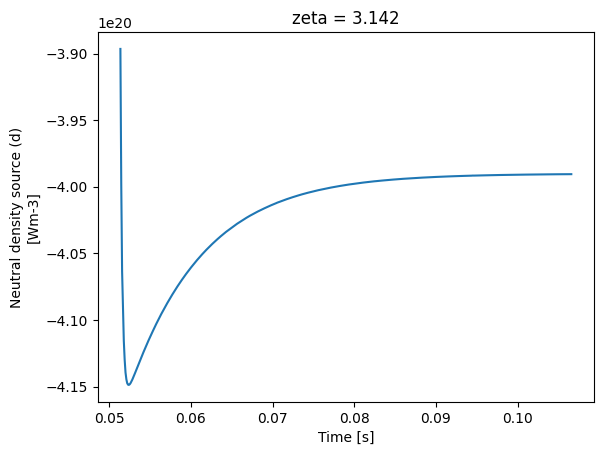

In [74]:
ds["pf_int_total_net"].plot()

In [72]:
(6.97-6.62)/6.97

0.05021520803443324

In [49]:
ds.data_vars

Data variables:
    Bxy                                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                                 (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_iz                               (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_rec                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed_target_recycle                    (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Edd+_cx                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_e_xlow                    (t, x, theta) float64 dask.arra

In [68]:
net["targets_d+"].values

array([-2.50548703e+21, -2.54071249e+21, -2.56107906e+21, -2.56377391e+21,
       -2.56834862e+21, -2.56944922e+21, -2.57090050e+21, -2.57139218e+21,
       -2.57180796e+21, -2.57196750e+21, -2.57202922e+21, -2.57200252e+21,
       -2.57192006e+21, -2.57179935e+21, -2.57165109e+21, -2.57148425e+21,
       -2.57130441e+21, -2.57111579e+21, -2.57092122e+21, -2.57072293e+21,
       -2.57052252e+21, -2.57032118e+21, -2.57011966e+21, -2.56991865e+21,
       -2.56971852e+21, -2.56951970e+21, -2.56932237e+21, -2.56912668e+21,
       -2.56893291e+21, -2.56874108e+21, -2.56855117e+21, -2.56836323e+21,
       -2.56817728e+21, -2.56799335e+21, -2.56781139e+21, -2.56763143e+21,
       -2.56745344e+21, -2.56727746e+21, -2.56710338e+21, -2.56693200e+21,
       -2.56676238e+21, -2.56659452e+21, -2.56642849e+21, -2.56626429e+21,
       -2.56610187e+21, -2.56594128e+21, -2.56578242e+21, -2.56562533e+21,
       -2.56546997e+21, -2.56531634e+21, -2.56516440e+21, -2.56501410e+21,
       -2.56486547e+21, -

In [58]:
(ds["Sd_target_recycle"] * ds["dv"]).isel(x=slice(2,-2)).sum().values

array(6.61786471e+21)

In [61]:
ds = casestore["base"].ds.isel(t=-1)
tot = 0
for name in m["targets"]:
    # tot += ds[f"pf_int_recycle_{name}_target_d"].values
    # target = ds.hermesm.select_region(targetname).squeeze
    tot += ds[f"pf_{name}_target_d+"].sum().values
    
tot

-6.971255365419361e+21

In [66]:
ds[f"pf_{target_name}_target_d+"].values

array([            nan,             nan, -2.21927464e+19, -2.44975586e+19,
       -2.92798982e+19, -3.69546501e+19, -4.81056327e+19, -6.33643142e+19,
       -8.30671428e+19, -1.06459480e+20, -1.35679217e+20, -1.89979007e+20,
       -2.71380582e+20, -3.46886926e+20, -3.66153103e+20, -3.22919965e+20,
       -2.63761792e+20, -2.41305413e+20,             nan,             nan])